In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import time
import os
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import (
    mean_squared_error,       
    mean_absolute_error,      
    r2_score,                
    mean_absolute_percentage_error,  
    mean_squared_log_error    # MSLE
)
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


In [2]:
df_raw= pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv", low_memory=False)
df = df_raw.copy()


# Feature engineering

In [3]:
df = pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv",low_memory=False)
df.drop(['gender', 'balls_per_over', 'series_name','name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams'], axis = 1, inplace = True)
df['all_rounder_score'] = (df['runs_scored']/90 + df['wickets_taken']*0.35)*20
df['fielding'] = (df['catches_taken'] * 5 + df['run_out_throw'] * 15 + df['run_out_direct'] * 4)
df['batting_impact'] = ((2 * df['sixes_scored'].fillna(0) + df['fours_scored'].fillna(0)) /df['balls_faced'].replace(0, np.nan)).fillna(0)

df['bowling_impact'] = ( (3 * df['wickets_taken'].fillna(0) + df['dot_balls_as_bowler'].fillna(0)) / df['balls_bowled'].replace(0, np.nan)).fillna(0)

# LABEL ENCODING CATEROGICAL OR MULTI CLASS COLUMNS
label_encoder = LabelEncoder()

df['player_id'] = label_encoder.fit_transform(df['player_id'].fillna("Unknown"))

df['match_type'] = df['match_type'].fillna("Unknown")


match_type_map = { #Encoding to 0,1,2 etccc
    'T20': 0,
    'ODI': 1,
    'Test': 2,
    'MDM': 3,
    'ODM': 4,
    'Unknown': -1
}
df['match_type_code'] = df['match_type'].map(match_type_map)

# Step 3: Drop old string column
df = df.drop(columns=['match_type'])


df['player_team'] = label_encoder.fit_transform(df['player_team'].fillna("Unknown"))
df['opposition_team'] = label_encoder.fit_transform(df['opposition_team'].fillna("Unknown"))

df




,player_id,match_id,start_date,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,...,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,all_rounder_score,fielding,batting_impact,bowling_impact,match_type_code
0,922,1158348,21-08-2018,M King,10,1,30,1,0,1,...,275,211,5,8,17,2.222222,5,0.033333,0.0,0.0
1,922,1182644,05-05-2019,M King,8,1,18,1,0,0,...,275,333,3,0,7,1.777778,0,0.055556,0.0,0.0
2,922,1275107,09-09-2021,M King,1,0,5,0,0,0,...,275,217,1,0,5,0.222222,0,0.000000,0.0,0.0
3,922,1275113,15-09-2021,M King,0,0,0,0,0,0,...,275,40,0,0,4,0.000000,0,0.000000,0.0,0.0
4,922,1275125,14-09-2021,M King,1,1,15,0,0,0,...,275,333,-5,0,-1,0.222222,0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,11770,1473475,20-04-2025,Naman Dhir,0,0,0,0,0,0,...,207,51,0,0,4,0.000000,0,0.000000,0.0,0.0
416708,11770,1473478,23-04-2025,Naman Dhir,0,0,0,0,0,1,...,207,297,0,8,12,0.000000,5,0.000000,0.0,0.0
416709,11770,1473482,27-04-2025,Naman Dhir,25,0,13,2,2,1,...,207,181,37,8,49,5.555556,5,0.461538,0.0,0.0
416710,11770,1473487,01-05-2025,Naman Dhir,0,0,0,0,0,0,...,207,252,0,0,4,0.000000,0,0.000000,0.0,0.0


In [4]:
print(df.columns.tolist())

['player_id', 'match_id', 'start_date', 'name_x', 'runs_scored', 'player_out', 'balls_faced', 'fours_scored', 'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled', 'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens', 'dot_balls_as_bowler', 'player_team', 'opposition_team', 'fantasy_score_batting', 'fantasy_score_bowling', 'fantasy_score_total', 'all_rounder_score', 'fielding', 'batting_impact', 'bowling_impact', 'match_type_code']


# Splitting the dataset for training and testing purpose

In [5]:
def split(df,date):
    train = df[df['start_date']< pd.to_datetime(date)]
    test = df[df['start_date']>= pd.to_datetime(date)]
    return train,test

df['start_date'] = pd.to_datetime(df['start_date'])
df_train, df_test = split(df, pd.to_datetime('2024-12-01'))

df_train.sort_values(by='start_date')
df_test.sort_values(by='start_date')

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

C:\Users\abhau\AppData\Local\Temp\ipykernel_28792\464633085.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_date'] = pd.to_datetime(df['start_date'])


In [6]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Generating rolling-window stats of past few games to analyze recent form

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Rolling stats function
def rolling_stats(group):
    group = group.sort_values('start_date')

    balls_faced = group['balls_faced'].replace(0, np.nan).astype(float)
    balls_bowled = group['balls_bowled'].replace(0, np.nan).astype(float)

    group['SR_match'] = (group['runs_scored'] / balls_faced) * 100
    group['ECO_match'] = group['runs_conceded'] / (balls_bowled / 6)

    group['SR_match'] = group['SR_match'].replace([np.inf, -np.inf], np.nan).clip(upper=300).fillna(0)
    group['ECO_match'] = group['ECO_match'].replace([np.inf, -np.inf], np.nan).clip(upper=20).fillna(0)

    group['strike_rate_1'] = group['SR_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['strike_rate_5'] = group['SR_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['strike_rate_10'] = group['SR_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['economy_rate_1'] = group['ECO_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['economy_rate_5'] = group['ECO_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['economy_rate_10'] = group['ECO_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['fours_1'] = group['fours_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['fours_5'] = group['fours_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['fours_10'] = group['fours_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['sixes_1'] = group['sixes_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['sixes_5'] = group['sixes_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['sixes_10'] = group['sixes_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['AR_1'] = group['all_rounder_score'].shift(1).rolling(window=1, min_periods=1).mean() * 10
    group['AR_5'] = group['all_rounder_score'].shift(1).rolling(window=5, min_periods=1).mean() * 10
    group['AR_10'] = group['all_rounder_score'].shift(1).rolling(window=10, min_periods=1).mean() * 10

    group['fantasy_1'] = group['fantasy_score_total'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasy_5'] = group['fantasy_score_total'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasy_10'] = group['fantasy_score_total'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasy_15'] = group['fantasy_score_total'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybat_1'] = group['fantasy_score_batting'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybat_5'] = group['fantasy_score_batting'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybat_10'] = group['fantasy_score_batting'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybat_15'] = group['fantasy_score_batting'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybowl_1'] = group['fantasy_score_bowling'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybowl_5'] = group['fantasy_score_bowling'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybowl_10'] = group['fantasy_score_bowling'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybowl_15'] = group['fantasy_score_bowling'].shift(1).rolling(window=15, min_periods=9).sum()

    group['runs_scored_5'] = group['runs_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['runs_scored_10'] = group['runs_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['wickets_taken_5'] = group['wickets_taken'].shift(1).rolling(window=5, min_periods=2).sum()
    group['wickets_taken_10'] = group['wickets_taken'].shift(1).rolling(window=10, min_periods=5).sum()

    return group

#Weighted Moving Average features
def apply_wma_features(df, span=5, w=1.6):
    df = df.copy()
    base_weights = np.array([w**(span - i - 1) for i in range(span)])
    base_weights /= base_weights.sum()

    wma_cols = {
        'runs_scored': 'runs_scored_wma',
        'SR_match': 'SR_match_wma',
        'ECO_match': 'ECO_match_wma',
        'fantasy_score_batting': 'fantasybat_wma',
        'fantasy_score_bowling': 'fantasybowl_wma',
        'batting_impact': 'bat_wma',
        'bowling_impact':'bowl_wma',
        'fantasy_score_total': 'fantasy_wma'
    }

    for col, new_col in wma_cols.items():
        if col in df.columns:
            def wma_func(x):
                def weighted_rolling(arr):
                    L = len(arr)
                    if L == 0:
                        return np.nan
                    weights = base_weights[-L:]  # trim weights
                    weights /= weights.sum()     # normalize
                    return np.dot(arr, weights)
                return x.shift(1).rolling(window=span, min_periods=2).apply(weighted_rolling, raw=True)

            df[new_col] = df.groupby('player_id')[col].transform(wma_func)
        else:
            print(f"[WMA] Column '{col}' missing in DataFrame.")

    return df

df_stats = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)

df_stats = apply_wma_features(df_stats, span=5)

def player_features(data):
    feature_data = []

    for player_id, group in data.groupby(['player_id']):
        group = group.sort_values('start_date')
        group = rolling_stats(group)
        group = apply_wma_features(group, span=5)
        feature_data.append(group)

    result_df = pd.concat(feature_data).reset_index(drop=True)

    return result_df[[
        'player_id', 'match_id', 'match_type_code', 'start_date', 'fantasy_score_total',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15','fantasybowl_10','fantasybowl_5','fantasybat_10','fantasybat_5', 'strike_rate_5', 'strike_rate_10', 'economy_rate_10',
        'fours_10','sixes_10', 'AR_5', 'AR_10','bat_wma','bowl_wma','fantasy_wma',
        'runs_scored_5', 'runs_scored_10',
        'wickets_taken_5', 'wickets_taken_10',
        'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',
        'fantasybat_wma', 'fantasybowl_wma',  'order_seen']]
    

100%|██████████| 11771/11771 [03:25<00:00, 57.34it/s]


<Axes: >

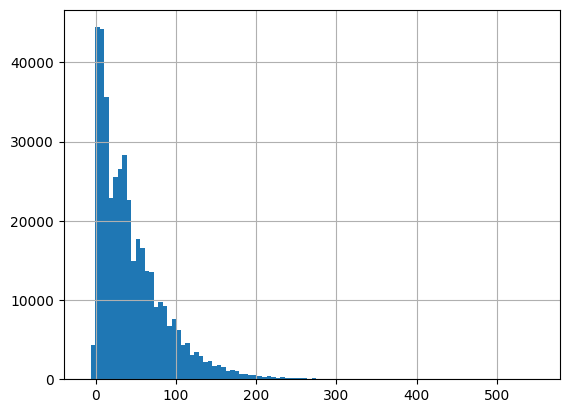

In [52]:
df['fantasy_score_total'].hist(bins=100)


In [8]:
from tqdm import tqdm
tqdm.pandas() 
def get_features_all_players(df):
    #  Apply rolling stats and WMA features
    df_feat = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)
    df_feat = apply_wma_features(df_feat, span=5)

    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill only numeric columns
    numeric_cols = df_feat.select_dtypes(include='number').columns
    df_feat[numeric_cols] = df_feat[numeric_cols].fillna(0)

    
    match_type_cols = [col for col in df_feat.columns if col.startswith("match_type_")]

   
    selected_cols = [
        'player_id', 'match_id', 'start_date', 'fantasy_score_total','match_type_code',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',  'fantasybowl_10', 'fantasybowl_5',
        'fantasybat_10', 'fantasybat_5','strike_rate_5', 'strike_rate_10', 'economy_rate_10','bat_wma','bowl_wma','fantasy_wma',
        'fours_10', 'sixes_10', 'AR_5', 'AR_10',  'runs_scored_5', 'runs_scored_10',
        'wickets_taken_5', 'wickets_taken_10',  'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',
        'fantasybat_wma', 'fantasybowl_wma', 'order_seen' ]
    all_cols = selected_cols + match_type_cols
    return df_feat[all_cols]


In [9]:
df_all_features = get_features_all_players(df)
df_train_features = df_all_features[df_all_features['start_date'] < '2024-12-01']
df_test_features = df_all_features[df_all_features['start_date'] >= '2024-12-01']


  0%|          | 0/11771 [00:00<?, ?it/s]

100%|██████████| 11771/11771 [03:02<00:00, 64.59it/s]


In [10]:
df_all_features.head()

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,runs_scored_10,wickets_taken_5,wickets_taken_10,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_code
0,0,1163062,2018-11-01,33,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0,1283024,2021-10-16,4,0.0,42.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0
2,0,1283026,2021-10-17,29,0.0,5.2,44.4,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,0,1283029,2021-10-19,1,0.0,37.7,79.2,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0
4,0,1283033,2021-10-20,6,0.0,1.3,80.4,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


# Creating Training and Testing data

In [11]:
df_train_features.sort_values(by='start_date')

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,runs_scored_10,wickets_taken_5,wickets_taken_10,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_code
236831,6899,63963,2001-12-19,22,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,2.0
118353,3433,63963,2001-12-19,71,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5,2.0
61414,1860,63963,2001-12-19,44,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,2.0
402045,11344,63963,2001-12-19,62,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3,2.0
342371,9676,63963,2001-12-19,119,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108751,3203,1462596,2024-11-30,41,0.0,5.2,188.4,269.0,520.0,212.0,...,17.0,5.0,8.0,8.858396,6.996791,0.619835,-0.372077,26.109176,9,0.0
359590,10170,1433379,2024-11-30,0,2.0,94.9,422.4,687.0,1058.0,16.0,...,529.0,0.0,0.0,52.080389,5.131816,39.229739,46.239571,2.480551,3,2.0
92045,2662,1432227,2024-11-30,35,0.0,2.6,48.0,170.0,396.0,24.0,...,87.0,0.0,0.0,13.787995,0.000000,1.243563,0.852996,0.000239,0,0.0
138434,4036,1433379,2024-11-30,36,2.0,232.7,289.2,400.0,480.0,38.0,...,272.0,0.0,0.0,48.392707,1.523778,30.841148,35.091685,4.961084,0,2.0


In [12]:
df_test_features.sort_values(by='start_date')

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,runs_scored_10,wickets_taken_5,wickets_taken_10,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma,order_seen,match_type_code
329460,9327,1442688,2024-12-01,13,0.0,78.0,272.4,445.0,594.0,34.0,...,288.0,0.0,0.0,116.749832,0.000000,23.897036,31.069082,5.829502,0,0.0
67213,2008,1444652,2024-12-01,6,0.0,39.0,369.6,574.0,767.0,477.0,...,43.0,8.0,17.0,163.644276,7.562127,11.348605,16.627257,63.448984,0,0.0
78301,2286,1442688,2024-12-01,40,0.0,91.0,295.2,402.0,504.0,60.0,...,201.0,0.0,0.0,48.761719,0.000000,17.448865,33.070158,2.977184,0,0.0
80477,2339,1444652,2024-12-01,42,0.0,117.0,574.8,848.0,1007.0,187.0,...,513.0,3.0,5.0,102.173778,5.622009,46.526202,59.939722,23.890735,2,0.0
83734,2421,1444652,2024-12-01,9,0.0,53.3,316.8,381.0,503.0,68.0,...,209.0,0.0,0.0,195.461316,0.000000,35.426244,49.959714,3.101445,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361660,10220,1473500,2025-05-20,16,0.0,13.0,234.0,457.0,672.0,24.0,...,330.0,0.0,0.0,98.414197,0.000000,37.951984,48.108039,5.519432,2,0.0
362414,10242,1485778,2025-05-20,17,0.0,49.4,111.6,156.0,303.0,71.0,...,49.0,1.0,1.0,85.118643,0.000154,7.680953,8.263274,1.551147,0,0.0
308529,8754,1485778,2025-05-20,2,0.0,7.8,315.6,424.0,475.0,362.0,...,22.0,7.0,10.0,0.007228,5.434715,0.000339,-0.992144,29.101866,0,0.0
258473,7468,1473500,2025-05-20,0,0.0,7.8,117.6,307.0,522.0,266.0,...,1.0,3.0,10.0,0.000355,11.296532,0.000020,0.000003,25.813145,0,0.0


In [13]:
print(df_train_features.columns)
print(df_test_features.columns)

Index(['player_id', 'match_id', 'start_date', 'fantasy_score_total',
       'match_type_code', 'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',
       'fantasybowl_10', 'fantasybowl_5', 'fantasybat_10', 'fantasybat_5',
       'strike_rate_5', 'strike_rate_10', 'economy_rate_10', 'bat_wma',
       'bowl_wma', 'fantasy_wma', 'fours_10', 'sixes_10', 'AR_5', 'AR_10',
       'runs_scored_5', 'runs_scored_10', 'wickets_taken_5',
       'wickets_taken_10', 'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',
       'fantasybat_wma', 'fantasybowl_wma', 'order_seen', 'match_type_code'],
      dtype='object')
Index(['player_id', 'match_id', 'start_date', 'fantasy_score_total',
       'match_type_code', 'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',
       'fantasybowl_10', 'fantasybowl_5', 'fantasybat_10', 'fantasybat_5',
       'strike_rate_5', 'strike_rate_10', 'economy_rate_10', 'bat_wma',
       'bowl_wma', 'fantasy_wma', 'fours_10', 'sixes_10', 'AR_5', 'AR_10',
       'runs_score

In [14]:
df_train_features = df_train_features.reset_index(drop=True)
df_test_features = df_test_features.reset_index(drop=True)

In [53]:
X_train = df_train_features.drop(['fantasy_score_total','AR_10', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
       'economy_rate_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen','match_type_code',
        'sixes_10'], axis = 1)
y_train = df_train_features['fantasy_score_total']

X_test = df_test_features.drop(['fantasy_score_total', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
        'economy_rate_10','AR_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen','match_type_code',
        'sixes_10'], axis = 1)
y_test = df_test_features['fantasy_score_total']

## CORRELATION MATRIX OF TRAINING DATA

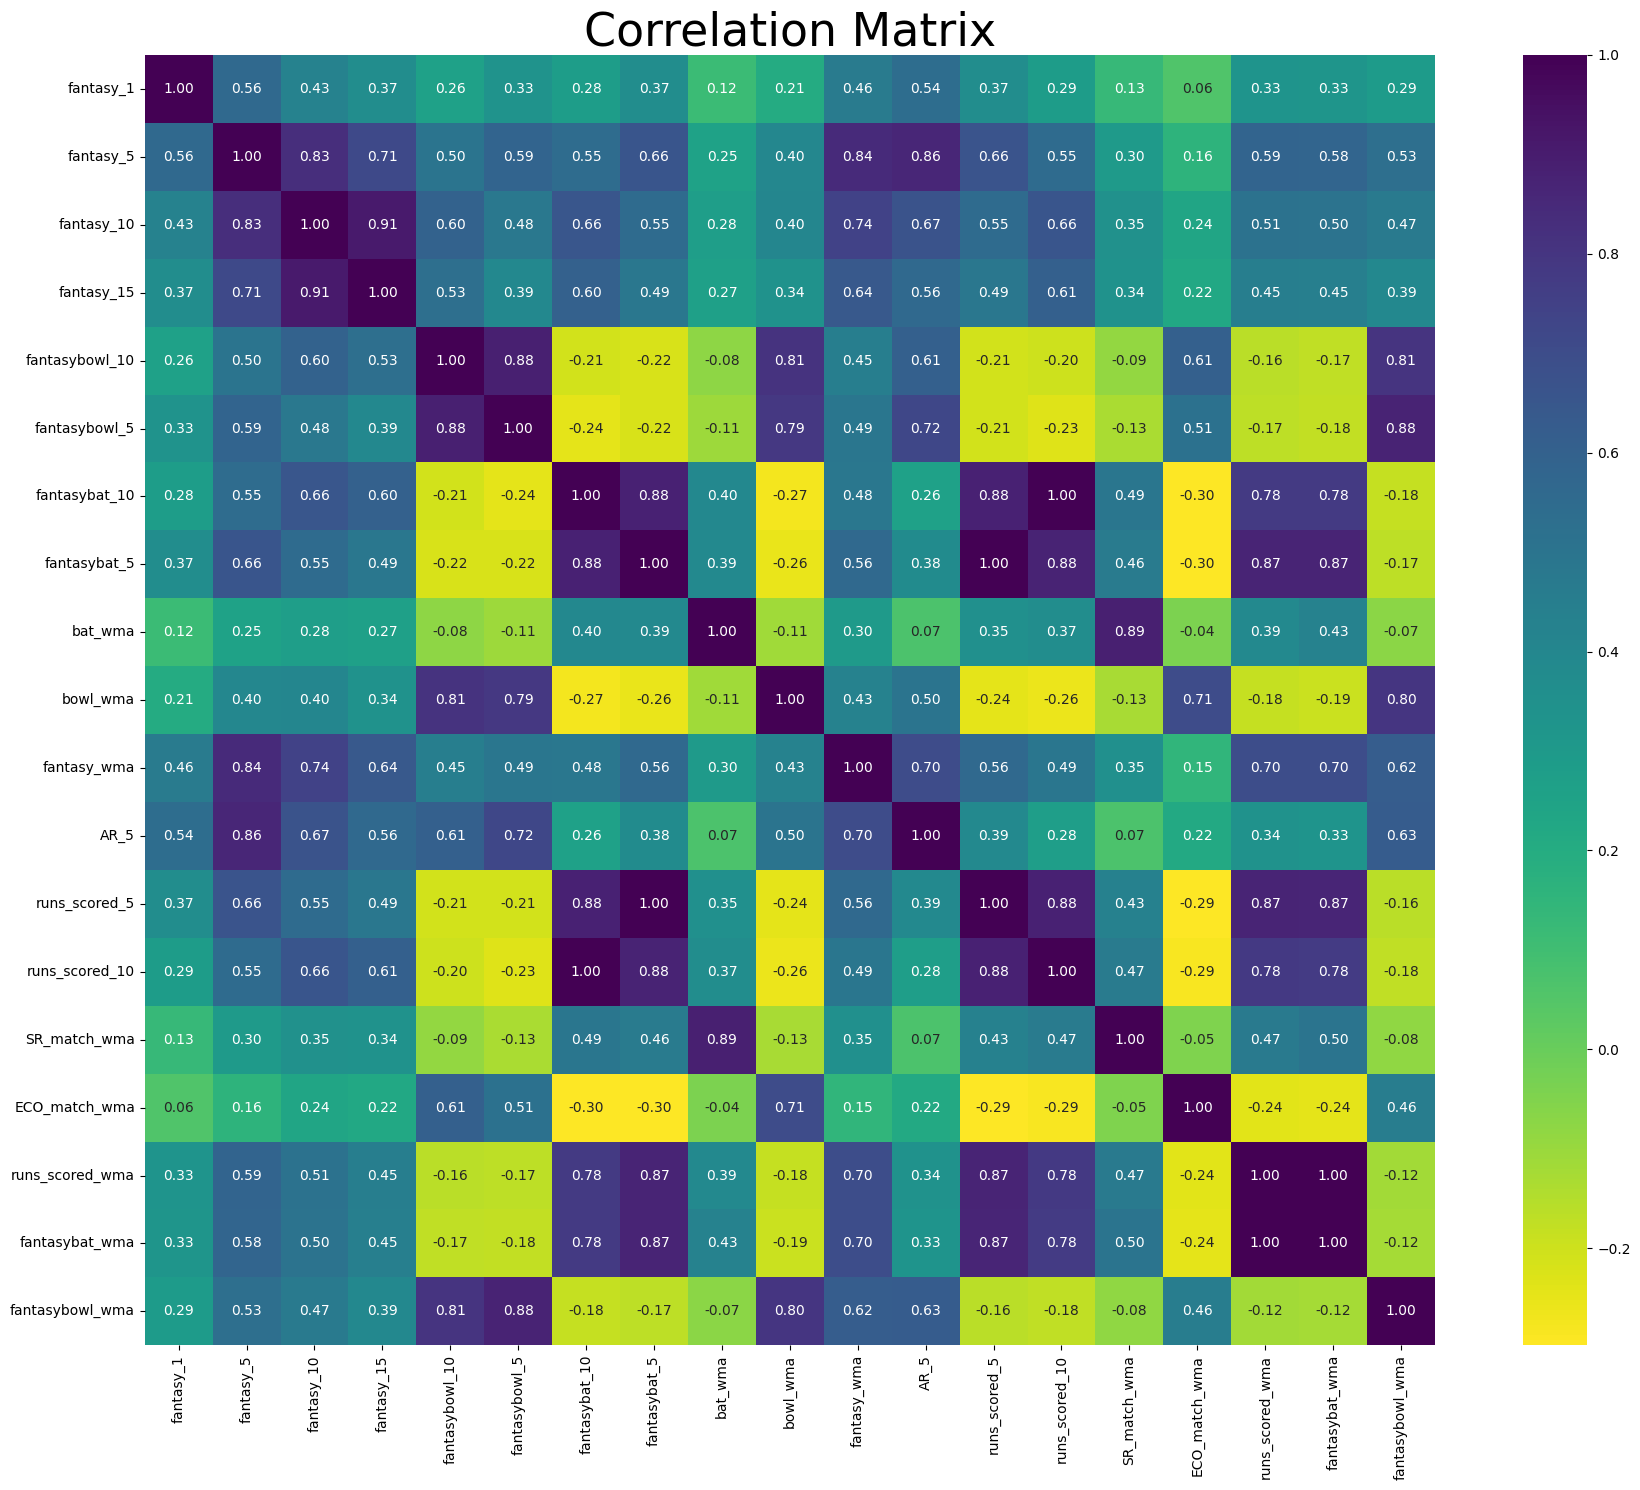

In [54]:
corr_matrix = X_train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r', fmt='.2f', square=True)
plt.title("Correlation Matrix",fontsize=33)
plt.tight_layout()
plt.show()

In [55]:
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [56]:
X_test

,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,fantasy_wma,AR_5,runs_scored_5,runs_scored_10,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma
0,5.2,46.8,103.0,161.0,36.0,19.2,27.0,3.6,0.000000,0.000000,4.930238,1.333333,3.0,3.0,23.252598,0.000000,0.628046,0.930190,0.000043
1,26.0,66.0,95.0,179.0,52.0,38.4,3.0,3.6,0.000000,0.000000,8.589346,1.333333,3.0,3.0,37.204157,0.000000,1.004874,1.488304,3.101174
2,20.8,61.2,99.0,176.0,44.0,19.2,15.0,18.0,0.000000,0.000000,11.286684,1.333333,3.0,3.0,0.000913,0.000000,0.294641,2.325486,4.961071
3,9.1,78.0,234.0,405.0,158.0,30.0,48.0,24.0,0.200253,0.106724,6.628550,21.555556,17.0,44.0,100.060852,11.261242,3.447362,4.286794,-1.657770
4,78.0,98.4,237.0,457.0,106.0,-2.4,99.0,76.8,0.424755,0.134738,22.232089,19.555556,44.0,75.0,166.604487,7.601006,8.109732,14.572985,3.658584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21107,2.6,266.4,409.0,540.0,82.0,81.6,287.0,160.8,0.393973,0.000000,36.852698,42.222222,95.0,209.0,160.257587,0.000000,17.238486,23.921838,8.930728
21108,5.2,232.8,411.0,539.0,82.0,48.0,289.0,160.8,0.233474,0.000000,39.101498,42.222222,95.0,209.0,110.903819,0.000000,18.856042,27.163981,7.938188
21109,15.6,144.0,397.0,510.0,90.0,38.4,267.0,81.6,0.000011,0.000000,4.558567,21.777778,49.0,192.0,0.012833,0.000000,0.001850,-0.991624,1.550580
21110,63.7,171.6,352.0,493.0,98.0,38.4,214.0,109.2,0.089453,0.000000,15.202493,28.000000,63.0,155.0,37.280469,0.000000,4.849084,7.172058,4.031301


In [57]:
X_train 

,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,fantasy_wma,AR_5,runs_scored_5,runs_scored_10,SR_match_wma,ECO_match_wma,runs_scored_wma,fantasybat_wma,fantasybowl_wma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,42.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,70.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.2,44.4,0.0,0.0,0.0,39.6,0.0,0.0,0.000000,0.000000,0.000000,35.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,37.7,79.2,0.0,0.0,0.0,69.6,0.0,0.0,0.000000,0.000000,0.000000,46.666667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.3,80.4,0.0,0.0,0.0,62.4,0.0,3.6,0.000000,0.000000,0.000000,36.666667,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395595,85.8,205.2,185.0,0.0,40.0,48.0,121.0,133.2,0.206724,0.000000,27.984689,35.555556,80.0,89.0,115.251482,4.030824,12.512188,18.403171,5.581647
395596,2.6,158.4,187.0,0.0,40.0,28.8,119.0,105.6,0.330745,0.000000,41.193387,28.000000,63.0,89.0,144.699000,6.449318,19.223673,28.263044,8.929989
395597,22.1,157.2,204.0,0.0,40.0,28.8,132.0,104.4,0.233681,0.040799,36.658421,27.555556,62.0,100.0,118.600597,1.529965,17.013520,24.720193,7.937784
395598,2.6,153.6,206.0,206.0,40.0,28.8,130.0,100.8,0.056386,0.065278,6.651779,27.111111,61.0,100.0,31.017268,2.448415,3.413269,2.652109,0.000235


# Training on XG-BOOST MODEL

In [58]:
from xgboost import XGBRegressor
# Training the model
model = XGBRegressor(n_estimators=300, learning_rate=0.161, max_depth=6, random_state=42)
model.fit(X_train, y_train)
# Predict
fantasy_score_total_predicted = model.predict(X_test)


In [59]:
importances = model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp_df.head(10))


            feature  importance
3        fantasy_15    0.299435
11             AR_5    0.153884
14     SR_match_wma    0.040427
0         fantasy_1    0.038469
16  runs_scored_wma    0.036887
15    ECO_match_wma    0.036121
12    runs_scored_5    0.035342
9          bowl_wma    0.035219
1         fantasy_5    0.033944
13   runs_scored_10    0.031915


### PLOT OF ACTUAL VS PREDICTED FANTASY SCORE

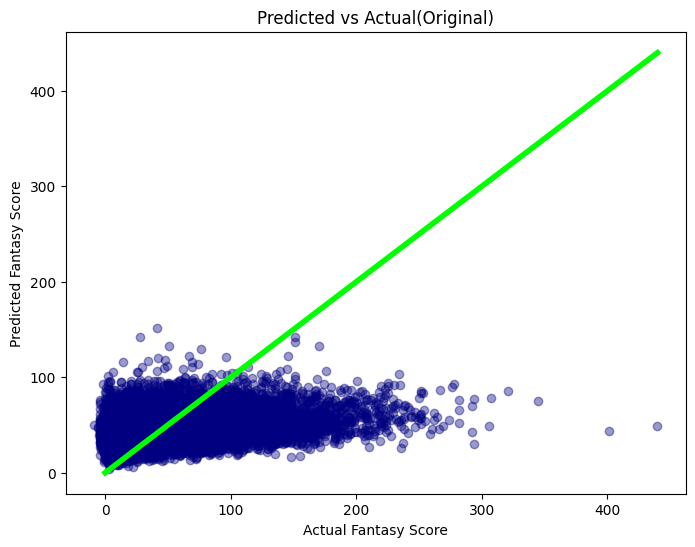

In [60]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, fantasy_score_total_predicted, alpha=0.4,color='navy')
plt.xlabel("Actual Fantasy Score")
plt.ylabel("Predicted Fantasy Score")
plt.title("Predicted vs Actual(Original)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='lime',linewidth=4)  # perfect line
plt.show()


In [61]:
# Creating a DataFrame with actual and predicted fantasy_score_total
df_predictions = pd.DataFrame({
    'player_id': df_test_features['player_id'],
    'match_id': df_test_features['match_id'],
    'fantasy_score_total': df_test_features['fantasy_score_total'],
    'fantasy_score_total_predicted': fantasy_score_total_predicted
})
df_predictions.head()

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,2,1474423,20,15.048065
1,2,1474424,16,15.869555
2,2,1474429,2,16.030535
3,4,1443059,60,34.215816
4,4,1443062,22,43.651890


In [62]:
def mape_sum_top11_per_match(group):
    actual_top11_sum = group.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum()
    predicted_top11_sum = group.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum()
    
    # Avoid division by zero
    if actual_top11_sum == 0:
        return np.nan
    
    return abs(actual_top11_sum - predicted_top11_sum) / actual_top11_sum * 100
mape_by_match = df_predictions.groupby('match_id')[['fantasy_score_total', 'fantasy_score_total_predicted']].apply(mape_sum_top11_per_match)
mape = mape_by_match.mean()

In [63]:
print(f" MAPE: {mape:.2f} %")

 MAPE: 27.86 %


PRIME FOCUS IS BEST POSSIBLE OPTIMAL TOP 11 SCORE  TO SELECT BEST POSSIBLE TOP 11 TEAM

In [64]:
Top11_df = (
    df_predictions.groupby('match_id').apply(
        lambda x: pd.Series({
            'sum_top11_actual': x.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum().round(0),
            'sum_top11_predict': x.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum().round(0)
        })
    ).reset_index()
)
Top11_df['sum_top11_actual'] = Top11_df['sum_top11_actual'].astype(int)
Top11_df['sum_top11_predict'] = Top11_df['sum_top11_predict'].astype(int)


C:\Users\abhau\AppData\Local\Temp\ipykernel_28792\1313617572.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_predictions.groupby('match_id').apply(


In [65]:
df_predictions # PREDICTIONS FOR INDIVIDUAL PLAYERS

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,2,1474423,20,15.048065
1,2,1474424,16,15.869555
2,2,1474429,2,16.030535
3,4,1443059,60,34.215816
4,4,1443062,22,43.651890
...,...,...,...,...
21107,11770,1473475,4,38.112518
21108,11770,1473478,12,37.509998
21109,11770,1473482,49,38.863392
21110,11770,1473487,4,40.471581


In [66]:
Top11_df

,match_id,sum_top11_actual,sum_top11_predict
0,1421074,832,477
1,1426556,1278,837
2,1426557,1334,849
3,1426558,1818,790
4,1426559,1183,959
...,...,...,...
946,1484052,762,551
947,1485778,649,504
948,1486225,846,461
949,1486227,688,490


#### Function To find optimal relation between fantasy score of actual Top 11 and predicted top 11 players

In [67]:
def evaluate_match(df, k=11):
    actual_top_k_sum = df['fantasy_score_total'].nlargest(k).sum()
    idx = df['fantasy_score_total_predicted'].nlargest(k).index
    return {
        'actual_top_11_sum': actual_top_k_sum,
        'model_actual_sum': df.loc[idx, 'fantasy_score_total'].sum(),
        'percent_of_optimal': df.loc[idx, 'fantasy_score_total'].sum() / actual_top_k_sum
    }

In [68]:
from tqdm import tqdm

evaluation_list = []

for match_id in tqdm(df_predictions['match_id'].unique()):
    df_match = df_predictions[df_predictions['match_id'] == match_id]

    if df_match['fantasy_score_total_predicted'].isnull().any() or df_match.empty:
        continue  

    result = evaluate_match(df_match)
    result['match_id'] = match_id
    evaluation_list.append(result)

df_eval_results = pd.DataFrame(evaluation_list)

# Average % of optimal across matches
mean_percent = df_eval_results['percent_of_optimal'].mean()
print(f"Avg % of optimal top-11 score captured: {mean_percent:.2%}")



100%|██████████| 951/951 [00:01<00:00, 499.21it/s]

Avg % of optimal top-11 score captured: 71.53%


## ^^^ Predicted 11 captures about 72% of the best possible fantasy score on average. Which is decent enough for real life fantasy model

In [69]:
from datetime import datetime
import pandas as pd

def predict_top11_team(player_ids, match_date, df_full, model):
    match_date = pd.to_datetime(match_date)

    # avoid forward bias
    df_before = df_all_features[df_all_features ['start_date'] < match_date]

    # Generating features
    df_features = get_features_all_players(df_before)

    # Gets the latest feature rows for those 22 players
    df_match_players = df_features[df_features['player_id'].isin(player_ids)]
    df_latest = df_match_players.sort_values('start_date').groupby('player_id').tail(1)

    # Predict
    X = df_latest[model.feature_names_in_]
    df_latest['predicted_score'] = model.predict(X)

    # Keeping relevant columns
    top11 = df_latest.sort_values('predicted_score', ascending=False).head(11)
    return top11[['player_id', 'full_name', 'predicted_score', 'fantasy_score_total']]


Function to identify player roles

In [70]:
def identify_player_role(df_player):
    total_matches = len(df_player)
    bowling_matches = (df_player['balls_bowled'] > 0).sum()
    batting_matches = (df_player['balls_faced'] > 0).sum()
    avg_order_seen = df_player['order_seen'].mean()

    bowling_pct = bowling_matches / total_matches if total_matches else 0
    batting_pct = batting_matches / total_matches if total_matches else 0

    if bowling_pct >= 0.7:
        if batting_pct >= 0.55 and avg_order_seen > 5.5:
            return 'All-Rounder'
        return 'Bowler'
    return 'Batsman'
player_roles = df.groupby('player_id').apply(identify_player_role).reset_index(name='player_role')


C:\Users\abhau\AppData\Local\Temp\ipykernel_28792\862209114.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_roles = df.groupby('player_id').apply(identify_player_role).reset_index(name='player_role')


In [71]:
df_predictions = df_predictions.merge(player_roles, on='player_id', how='left')
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,player_role
0,2,1474423,20,15.048065,Batsman
1,2,1474424,16,15.869555,Batsman
2,2,1474429,2,16.030535,Batsman
3,4,1443059,60,34.215816,Bowler
4,4,1443062,22,43.651890,Bowler
...,...,...,...,...,...
21107,11770,1473475,4,38.112518,Batsman
21108,11770,1473478,12,37.509998,Batsman
21109,11770,1473482,49,38.863392,Batsman
21110,11770,1473487,4,40.471581,Batsman


## INTERFERENCE PIPELINE

In [74]:
def top_11_inference_pipeline(df_predictions, match_id, player_ids):
   
    #  Filter for the 22 players in this match
    df_match = df_predictions[
        (df_predictions['match_id'] == match_id) &
        (df_predictions['player_id'].isin(player_ids))
    ]

    if df_match.empty or df_match.shape[0] < 11:
        raise ValueError("Match or player data missing, or fewer than 11 players.")

    #  Predicted top 11
    pred_top_11 = df_match.sort_values(by='fantasy_score_total_predicted', ascending=False).head(11)

    #  Actual top 11
    actual_top_11 = df_match.sort_values(by='fantasy_score_total', ascending=False).head(11)

    return (
        pred_top_11[['player_id', 'fantasy_score_total_predicted', 'fantasy_score_total']],
        actual_top_11[['player_id', 'fantasy_score_total']]
    )


In [75]:
df_predictions['match_id'] = df_predictions['match_id'].astype(int)


#### Selected Predicted and Actual Top-11 Players from Match Data 

In [76]:
def top_11_inference_pipeline(df_predictions, match_id, player_ids):
    df_match = df_predictions[
        (df_predictions['match_id'] == match_id) &
        (df_predictions['player_id'].isin(player_ids))
    ]

    if df_match.empty or df_match.shape[0] < 11:
        raise ValueError("Match or player data missing, or fewer than 11 players.")

    pred_top_11 = df_match.sort_values(by='fantasy_score_total_predicted', ascending=False).head(11)
    actual_top_11 = df_match.sort_values(by='fantasy_score_total', ascending=False).head(11)

    return (
        pred_top_11[['player_id', 'fantasy_score_total_predicted', 'fantasy_score_total']],
        actual_top_11[['player_id', 'fantasy_score_total']]
    )


In [38]:
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,player_role
0,2,1474423,20,14.002875,Batsman
1,2,1474424,16,17.077375,Batsman
2,2,1474429,2,16.285538,Batsman
3,4,1443059,60,28.996498,Bowler
4,4,1443062,22,28.733624,Bowler
...,...,...,...,...,...
21107,11770,1473475,4,36.248486,Batsman
21108,11770,1473478,12,35.350723,Batsman
21109,11770,1473482,49,37.068195,Batsman
21110,11770,1473487,4,33.384956,Batsman


In [49]:
df_predictions['match_id'] = df_predictions['match_id'].astype(str)

print(f"Number of players found: {len(player_ids)}")  # Should print 22

pred_11, act_11 = top_11_inference_pipeline(df_predictions, match_id, player_ids)


Number of players found: 22


In [73]:
match_id = 1474423
match_id = str(match_id)  # convert int to string

player_ids = df_predictions[df_predictions['match_id'] == match_id]['player_id'].tolist()

pred_11, act_11 = top_11_inference_pipeline(df_predictions, match_id, player_ids)

print(" Predicted Top 11:\n", pred_11)
print("\n Actual Top 11:\n", act_11)


 Predicted Top 11:
        player_id  fantasy_score_total_predicted  fantasy_score_total
8068        4682                      62.081455                   69
14120       8086                      55.961555                  142
2784        1636                      47.407574                   61
8128        4730                      41.017323                   64
2401        1462                      39.056980                   16
4106        2338                      38.881905                   43
11622       6787                      38.760498                   19
8867        5199                      35.189941                   21
5009        2825                      30.972084                    5
2022        1180                      30.972084                    4
1423         847                      30.972084                   17

 Actual Top 11:
        player_id  fantasy_score_total
14120       8086                  142
6719        3827                   72
8068        4682    

Evalauting predcition on a random selected match

In [ ]:
def evaluate_prediction(pred_df, actual_df):
    actual_top11_sum = actual_df['fantasy_score_total'].sum()
    predicted_actual_sum = pred_df['fantasy_score_total'].sum()
    
    percent_of_optimal = (predicted_actual_sum / actual_top11_sum) * 100 if actual_top11_sum > 0 else 0.0

    return {
        "Optimal (Actual) Score": actual_top11_sum,
        "Model's Score (Actual Values)": predicted_actual_sum,
        "Percent of Optimal Captured": round(percent_of_optimal, 2)
    }


In [ ]:
evaluation = evaluate_prediction(pred_11, act_11)

for k, v in evaluation.items():
    print(f"{k}: {v}")


Optimal (Actual) Score: 610
Model's Score (Actual Values): 462
Percent of Optimal Captured: 75.74


## Visualization

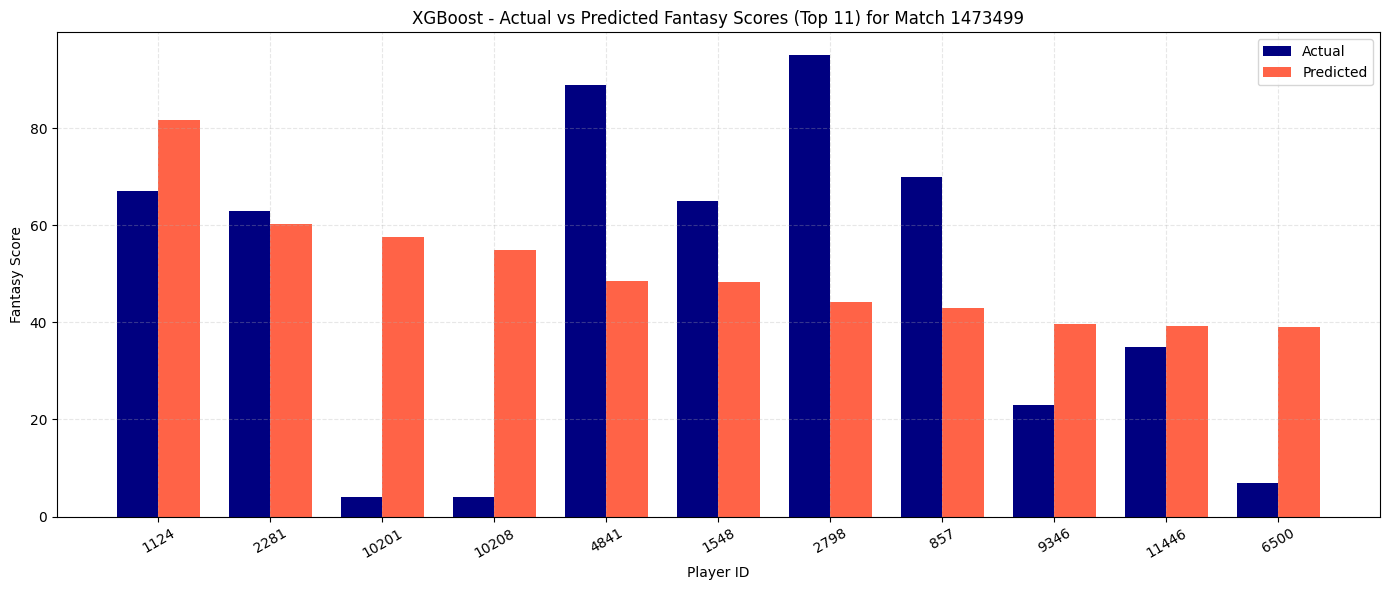

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df_predictions['match_id'] = df_predictions['match_id'].astype(str)
match_id = '1473499'

# Get top 11 by XGBoost predictions
df_match = (  df_predictions[df_predictions['match_id'] == match_id] .sort_values('fantasy_score_total_predicted', ascending=False) .head(11))

# Extract for plotting
player_ids = df_match['player_id'].astype(str).tolist()
actual_scores = df_match['fantasy_score_total'].tolist()
predicted_scores = df_match['fantasy_score_total_predicted'].tolist()

# Plotting
x = np.arange(len(player_ids))
width = 0.37

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, actual_scores, width, label='Actual', color='navy')
plt.bar(x + width/2, predicted_scores, width, label='Predicted', color='tomato')

plt.xlabel('Player ID')
plt.ylabel('Fantasy Score')
plt.title(f'XGBoost - Actual vs Predicted Fantasy Scores (Top 11) for Match {match_id}')
plt.xticks(x, player_ids, rotation=30)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df1 = df_raw.copy()
df1

In [103]:
# 1. Sort and get latest player name from match history
df['start_date'] = pd.to_datetime(df['start_date'])
df_sorted = df.sort_values(by='start_date', ascending=False)
df_names_latest = df_sorted[['player_id', 'name_x']].drop_duplicates('player_id', keep='first')

# 2. Ensure correct types
df_predictions['player_id'] = df_predictions['player_id'].astype(int)
df_names_latest['player_id'] = df_names_latest['player_id'].astype(int)

# 3. Merge name_x from df_names_latest, overwrite if already present
df_predictions = df_predictions.drop(columns=['name_x'], errors='ignore')  # avoid _x/_y issue
df_predictions = df_predictions.merge(df_names_latest, on='player_id', how='left')

# 4. Merge start_date from df_all_features
df_all_features['match_id'] = df_all_features['match_id'].astype(str)
df_predictions['match_id'] = df_predictions['match_id'].astype(str)

df_match_dates = df_all_features[['match_id', 'start_date']].drop_duplicates()
df_predictions = df_predictions.drop(columns=['start_date'], errors='ignore')  # drop if exists
df_predictions = df_predictions.merge(df_match_dates, on='match_id', how='left')

# 5. Final clean
df_predictions = df_predictions.drop_duplicates()



Final dataframe with all relevent columns

In [ ]:

cols_to_drop = [col for col in df_predictions.columns if col.startswith('name_x') and col != 'name_x']
df_predictions = df_predictions.drop(columns=cols_to_drop, errors='ignore')


In [107]:
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,player_role,name_x,start_date
0,2,1474423,20,15.048065,Batsman,M Tarimiala,2025-03-10
21,2,1474424,16,15.869554,Batsman,M Tarimiala,2025-03-11
42,2,1474429,2,16.030535,Batsman,M Tarimiala,2025-03-14
63,4,1443059,60,34.215816,Bowler,JJ Bazley,2024-12-17
126,4,1443062,22,43.651890,Bowler,JJ Bazley,2024-12-20
...,...,...,...,...,...,...,...
2596339,11770,1473475,4,38.112520,Batsman,Naman Dhir,2025-04-20
2596362,11770,1473478,12,37.510000,Batsman,Naman Dhir,2025-04-23
2596385,11770,1473482,49,38.863390,Batsman,Naman Dhir,2025-04-27
2596408,11770,1473487,4,40.471580,Batsman,Naman Dhir,2025-05-01


In [108]:
df_predictions.to_csv("df_predictions3.csv", index=False)
print("File saved as df_predictions_latest.csv")


File saved as df_predictions_latest.csv


## INTEGRATING THE XGBOOOST MODEL INTO GRADIO AND LAUNCHING

In [131]:
import gradio as gr
import pandas as pd
import numpy as np
df = pd.read_csv(r"D:\Win-Factor98\df_predictions3.csv")
df['start_date'] = pd.to_datetime(df['start_date'])
df['match_id'] = df['match_id'].astype(str)
if 'name_x' in df.columns:
    df = df.rename(columns={'name_x': 'player_name'})

def select_top_11(player_ids_text, match_date_text):
    pids = [int(x) for x in player_ids_text.split(',') if x.strip().isdigit()]
    mdate = pd.to_datetime(match_date_text)

    match_ids_on_date = df[df['start_date'] == mdate]['match_id'].unique()     # Matches played on given date
    if len(match_ids_on_date) == 0:
        return f"No match played on {mdate.date()}", None

    match_mask = df['match_id'].isin(match_ids_on_date)     # Ensure players played in one of those matches
    player_mask = df['player_id'].isin(pids)
    eligible_players = df[match_mask & player_mask]

    if len(eligible_players['player_id'].unique()) < 22:
        return "Entered players didn't play any match on this date", None

    # Historical data before match
    df_hist = df[(df['player_id'].isin(pids)) & (df['start_date'] < mdate)]
    if df_hist.empty:
        return "No past data available before this date", None

    df_hist = df_hist.sort_values('start_date', ascending=False).groupby('player_id').head(4)
    weights = np.array([0.5, 0.22, 0.17, 0.11])
    weights /= weights.sum()
    avg = df_hist.groupby(['player_id', 'player_name', 'player_role']).apply(
        lambda g: pd.Series({'Predicted Score': np.dot(
            g['fantasy_score_total_predicted'][:len(weights)],
            weights[:len(g)]
        )})
    ).reset_index()
    if avg.shape[0] < 11:
        return "Fewer than 11 players have enough recent data", None

    top11 = avg.sort_values('Predicted Score', ascending=False).head(11).round(0)
    top11 = top11.rename(columns={
        'player_id': 'ID', 'player_name': 'Name', 'player_role': 'Role'
    })[['ID', 'Name', 'Role', 'Predicted Score']]
    return f"Your Top 11", top11

with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown("                     # Breaking 11 - Fantasy Team Selector                ")
    ids = gr.Textbox(label="Player IDs (22–25)", lines=2)
    date = gr.Textbox(label="Match Date (YYYY-MM-DD)")
    btn = gr.Button("Select Top 11")
    msg = gr.Textbox(label="Result", interactive=False)
    table = gr.Dataframe(label="Top 11 Players", type="pandas", interactive=False)
    btn.click(select_top_11, [ids, date], [msg, table])
app.launch()


* Running on local URL:  http://127.0.0.1:7882
* To create a public link, set `share=True` in `launch()`.


In [ ]:
df_predictions[df_predictions['match_id'] == '1473493']['player_id'].unique() # TO GET PLAYER ID PRESENT IN A PARTICULAR MATCH


array([  754,   776,   990,  1570,  1740,  2122,  2262,  2605,  3188,
        4346,  5322,  5786,  6121,  7046,  7177,  7706,  8095,  8285,
        9179,  9542,  9743,  9775, 10058, 10537, 11770])

In [ ]:
df_predictions[df_predictions['match_id'] == '1473493']['start_date'].unique() 

<DatetimeArray>
['2025-05-06 00:00:00']
Length: 1, dtype: datetime64[ns]

# THESE REMAINING CODE BLOCKS CAN BE TOTALLY IGNORED AS IT CONTAINS WRONGLY USED PSO MODEL AS DISCUSSED IN GROUP.

#                                                               ❌ ❌  ❌

##### USING PARTICLE SWARM OPTIMIATION (PSO) TO MINIMIZE MAPE ACROSS TOP 11 TOTALS
 The objective function scales the predictions by a single weight factor

In [ ]:
from pyswarm import pso

def mape_PSO(w, df):
    scaled_pred = df['sum_top11_predict'] * w[0]
    mape = mean_absolute_percentage_error(df['sum_top11_actual'], scaled_pred)
    return mape * 100

# Function to call PSO

def run_pso(Top11_df, lower_bound=0.2, upper_bound=5.5):
    lb = [lower_bound]  
    ub = [upper_bound]  
    best_weight, best_score = pso(lambda w: mape_PSO(w, Top11_df), lb, ub, swarmsize=30, maxiter=40)
    print(f"\n Optimized weight: {best_weight[0]:.6f}, MAPE: {best_score:.2f} %")
    return best_weight[0], best_score

best_w, best_mape = run_pso(Top11_df)

Stopping search: Swarm best objective change less than 1e-08

 Optimized weight: 1.410595, MAPE: 16.27 %


### -->> AFTER USING PSO, MAPE REDUCED FROM 31 TO 17.25 WHICH IS A HUGE BOOST FOR THE MODEL

In [ ]:
df_predictions['fantasy_score_total_predicted_scaled'] = (df_predictions['fantasy_score_total_predicted']* 1.308).round(0).astype(int)
df_predictions['fantasy_score_total_predicted'] = (df_predictions['fantasy_score_total_predicted']).round(0).astype(int)
df_predictions.head(12)

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,player_role,name_x,fantasy_score_total_predicted_scaled
0,2,1474423,20,14,Batsman,M Tarimiala,18
1,2,1474424,16,19,Batsman,M Tarimiala,25
2,2,1474429,2,14,Batsman,M Tarimiala,18
3,4,1443059,60,23,Bowler,JJ Bazley,30
4,4,1443062,22,21,Bowler,JJ Bazley,28
5,4,1443065,38,34,Bowler,JJ Bazley,45
6,4,1443069,6,32,Bowler,JJ Bazley,42
7,4,1443076,13,30,Bowler,JJ Bazley,40
8,4,1443080,21,24,Bowler,JJ Bazley,32
9,17,1477679,4,18,Batsman,KS Kasse,24


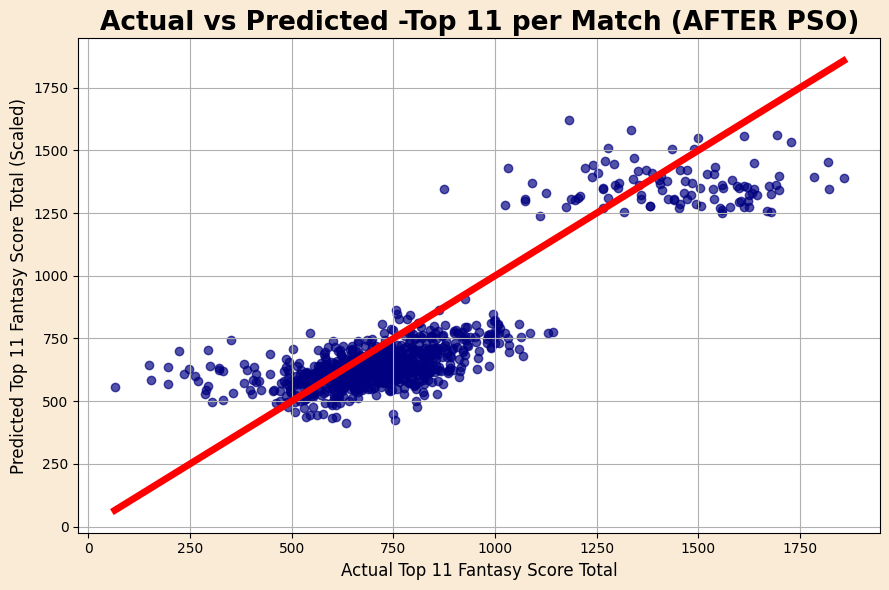

In [ ]:
best_weight = 1.308
Top11_df['sum_top11_predict_scaled'] = Top11_df['sum_top11_predict'] * best_weight

plt.figure(figsize=(9, 6),facecolor='antiquewhite')

plt.scatter(Top11_df['sum_top11_actual'], Top11_df['sum_top11_predict_scaled'], alpha=0.68, color='navy')
plt.plot([Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()], [Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()],color='red',linewidth=5)

plt.xlabel('Actual Top 11 Fantasy Score Total', fontsize=12)
plt.ylabel('Predicted Top 11 Fantasy Score Total (Scaled)', fontsize=12)
plt.title('Actual vs Predicted -Top 11 per Match (AFTER PSO)', fontsize=19,fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


# STACKED ENSEMBLING

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# base models
base_learners = [
    ('xgb', XGBRegressor(n_estimators=150, max_depth=9, verbosity=0, n_jobs=-1)),
    ('ridge', make_pipeline(StandardScaler(), Ridge(alpha=0.01))),
    ('gbr', GradientBoostingRegressor(n_estimators=80, random_state=42))
]

# meta-learner
meta_learner = HistGradientBoostingRegressor(max_iter=150, learning_rate=0.1, random_state=42)

# stacking regressor
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,  
    cv=4,
    n_jobs=-1
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict 
y_pred = stacking_model.predict(X_train)

# Evaluate
print("R2 Score:", r2_score(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

from joblib import dump, load

#Loading model
dump(stacking_model, 'stacking_model6.joblib')
stacking_model = load('stacking_model6.joblib')



R2 Score: 0.20099491005516834
MAE: 29.05615461201388
RMSE: 38.661317948512334


### ON TESTING DATA

In [ ]:
# Predict on test data
y_test_pred = stacking_model.predict(X_test)

print("R2 Score (Test):", r2_score(y_test, y_test_pred))
print("MAE (Test):", mean_absolute_error(y_test, y_test_pred))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_test_pred)))


R2 Score (Test): 0.1991185167735552
MAE (Test): 27.973055270198845
RMSE (Test): 37.413969370112135


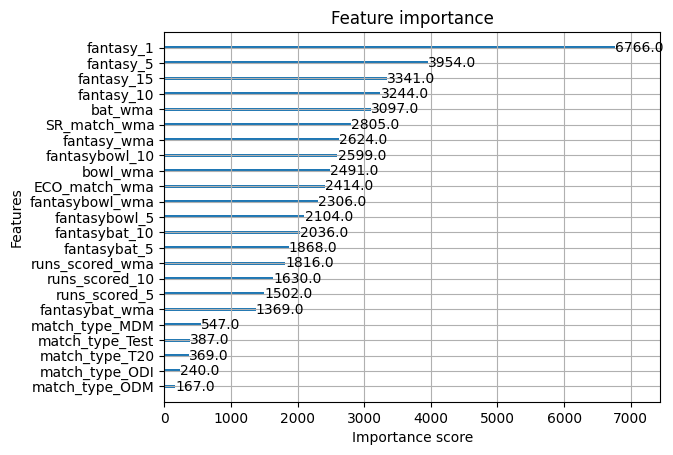

In [ ]:
from xgboost import plot_importance

xgb = base_learners[0][1]
xgb.fit(X_train, y_train)
plot_importance(xgb)
plt.show()


In [ ]:
df_all_features.columns

Index(['player_id', 'match_id', 'start_date', 'fantasy_score_total',
       'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15', 'fantasybowl_10',
       'fantasybowl_5', 'fantasybat_10', 'fantasybat_5', 'strike_rate_5',
       'strike_rate_10', 'economy_rate_10', 'bat_wma', 'bowl_wma',
       'fantasy_wma', 'fours_10', 'sixes_10', 'AR_5', 'AR_10', 'runs_scored_5',
       'runs_scored_10', 'wickets_taken_5', 'wickets_taken_10', 'SR_match_wma',
       'ECO_match_wma', 'runs_scored_wma', 'fantasybat_wma', 'fantasybowl_wma',
       'order_seen', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM',
       'match_type_T20', 'match_type_Test'],
      dtype='object')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from pyswarm import pso

df_top11_stack = (
    df_predictions[['match_id', 'player_id', 'predicted_score']] .sort_values(['match_id', 'predicted_score'], ascending=[True, False])  .groupby('match_id').head(11)
    .groupby('match_id')['predicted_score'].sum().reset_index(name='sum_top11_predict'))

# Merge with actuals
df_eval_stack = df_top11_stack.merge(Top11_df, on='match_id')

# Base MAPE
base_mape = mean_absolute_percentage_error(df_eval_stack['sum_top11_actual'], df_eval_stack['sum_top11_predict_x']) * 100

#  Run PSO
def obj(w):
    scaled = df_eval_stack['sum_top11_predict_x'] * w[0]
    return mean_absolute_percentage_error(df_eval_stack['sum_top11_actual'], scaled) * 100

best_w, best_mape = pso(obj, [1.1], [2.5], swarmsize=10, maxiter=200, debug=False)
print(f"[Stacking] Base MAPE: {base_mape:.2f}% | PSO MAPE: {best_mape:.2f}% | Best Weight: {best_w[0]:.4f}")

KeyError: "['predicted_score'] not in index"

## Top 11 Mape after PSO of Stacked Ensembling Model is 16.17% :)

In [ ]:
df_predictions['Stacked_Score_PSO'] = df_predictions['predicted_score'] * 1.4367
df_predictions.columns

#### Creating a dataframe to compare stacked+PSO predicted scores with actual

In [ ]:
cols_to_drop = ['fantasy_score_total_predicted', 'fantasy_score_total_predicted_scaled','final_score','final_score_Stacked']
df_stacked = df_predictions.drop(columns=cols_to_drop, errors='ignore').round(0)

df_stacked

In [ ]:
top11_df = (
    df_stacked
    .groupby('match_id')
    .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO'))
    .reset_index(drop=True)
)

C:\Users\abhau\AppData\Local\Temp\ipykernel_1924\2963418355.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO'))


In [ ]:
# Top-11 predicted total per match using Stacked_Score_PSO
df_top11_sum = (
    df_stacked
    .groupby('match_id')
    .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO')['Stacked_Score_PSO'].sum())
    .reset_index(name='sum_top11_predict')
)

# Merge with actual Top-11 scores
df_top11_eval = df_top11_sum.merge(
    Top11_df[['match_id', 'sum_top11_actual']], 
    on='match_id'
)

C:\Users\abhau\AppData\Local\Temp\ipykernel_1924\3883572081.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(11, 'Stacked_Score_PSO')['Stacked_Score_PSO'].sum())


In [ ]:
df_stacked

### Comparing ACTUAL VS PREDICTED FANTASY SCORE OF TOP 11 IN A RANDOM MATCH

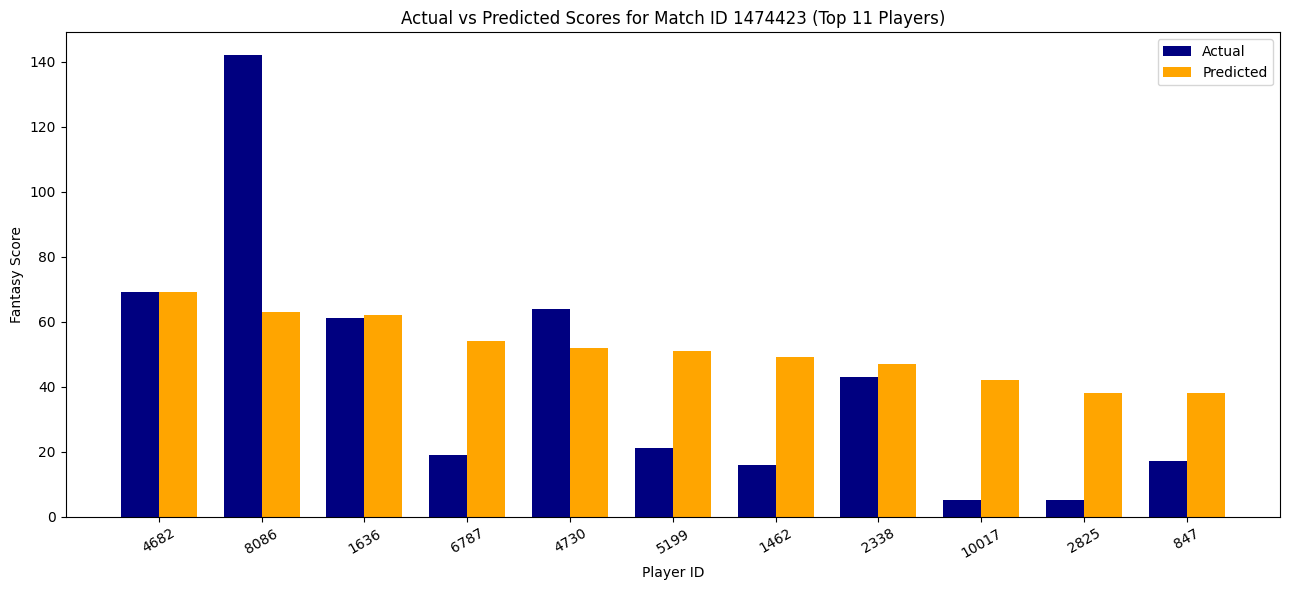

In [ ]:
df_stacked['match_id'] = df_stacked['match_id'].astype(str)
match_id = '1474423' 

# Get top 11 players for the match
df_match = (
    df_stacked[df_stacked['match_id'] == match_id] .sort_values('Stacked_Score_PSO', ascending=False).head(11))

player_ids = df_match['player_id'].astype(str).tolist()
actual_scores = df_match['fantasy_score_total'].tolist()
predicted_scores = df_match['Stacked_Score_PSO'].tolist()

#Plot
x = np.arange(len(player_ids))
width = 0.37

plt.figure(figsize=(13, 6))
plt.bar(x - width/2, actual_scores, width, label='Actual', color='navy')
plt.bar(x + width/2, predicted_scores, width, label='Predicted', color='orange')

plt.xlabel('Player ID')
plt.ylabel('Fantasy Score')
plt.title(f'Actual vs Predicted Scores for Match ID {match_id} (Top 11 Players)')
plt.xticks(x, player_ids, rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


### Actual vs Predicted Total Top 11 Fantasy Scores

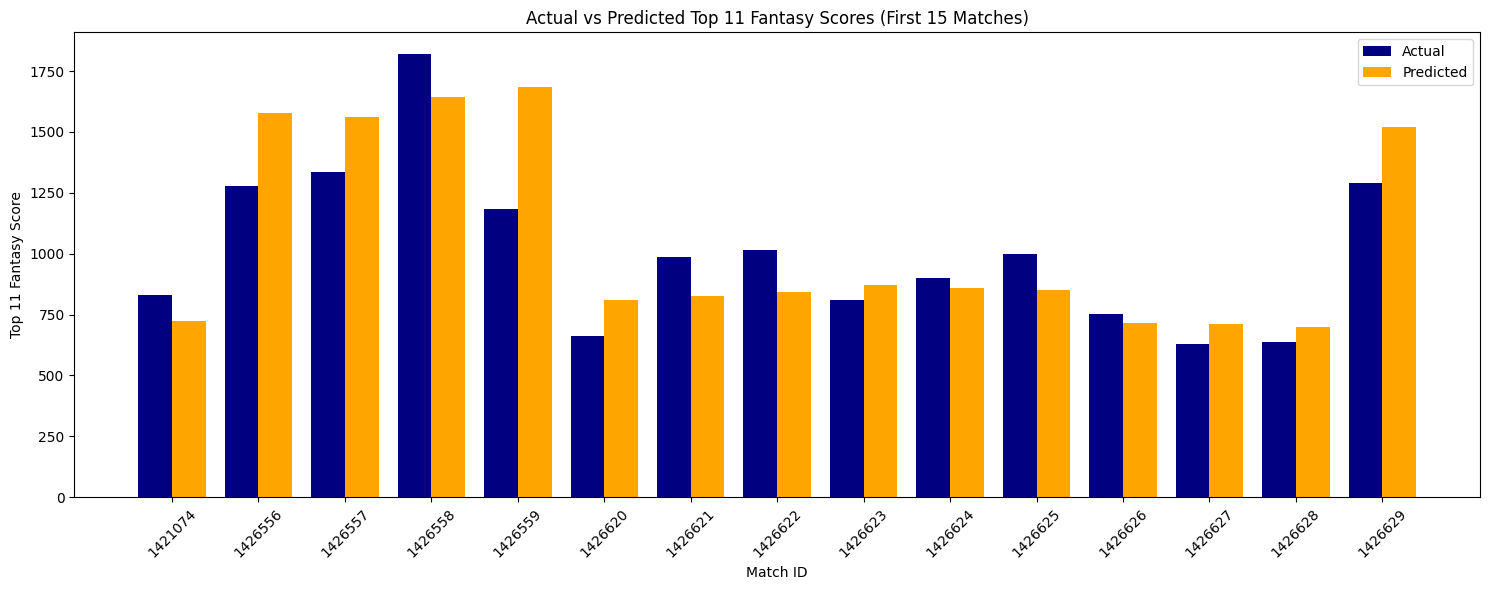

In [ ]:
# only first 15 rows
set = df_top11_eval.head(15)

# Data
matches = set['match_id'].astype(str).tolist()
actual = set['sum_top11_actual'].tolist()
predicted = set['sum_top11_predict'].tolist()

x = np.arange(len(matches))
width = 0.39

# Plot
plt.figure(figsize=(15, 6))
plt.bar(x - width/2, actual, width, label='Actual', color='navy')
plt.bar(x + width/2, predicted, width, label='Predicted', color='orange')
plt.xlabel('Match ID')
plt.ylabel('Top 11 Fantasy Score')
plt.title('Actual vs Predicted Top 11 Fantasy Scores (First 15 Matches)')
plt.xticks(x, matches, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df_top11_eval # FOR TOP 11 TEAMS